<a href="https://colab.research.google.com/github/AshishGusain17/via_google_colab/blob/master/chess_players.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline
import pandas as pd
import os,shutil,math,scipy,cv2
import numpy as np
import matplotlib.pyplot as plt
import random as rn
import seaborn as sn


from sklearn.utils import shuffle
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix,roc_curve,auc

from PIL import Image
from PIL import Image as pil_image
from PIL import ImageDraw

from time import time
from glob import glob
from tqdm import tqdm
from skimage.io import imread
from IPython.display import SVG

from scipy import misc,ndimage
from scipy.ndimage.interpolation import zoom
# from scipy.ndimage import imread

import keras
from keras import backend as K
from keras.utils.np_utils import to_categorical
from keras import layers
from keras.preprocessing.image import save_img
from keras.utils.vis_utils import model_to_dot
from keras.applications.vgg16 import VGG16,preprocess_input
from keras.models import Sequential,Input,Model
from keras.layers import Dense,Flatten,Dropout,Concatenate,GlobalAveragePooling2D,Lambda,ZeroPadding2D
from keras.layers import SeparableConv2D,BatchNormalization,MaxPooling2D,Conv2D
from keras import regularizers
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam,SGD
from keras.utils.vis_utils import plot_model
from keras.callbacks import ModelCheckpoint,EarlyStopping,TensorBoard,CSVLogger,ReduceLROnPlateau,LearningRateScheduler

In [13]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
def show_final_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    ax[0].set_title('loss')
    ax[0].plot(history.epoch, history.history["loss"], label="Training loss")
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax[1].set_title('acc')
    ax[1].plot(history.epoch, history.history["accuracy"], label="Training accuracy")
    ax[1].plot(history.epoch, history.history["val_accuracy"], label="Validation accuracy")
    ax[0].legend()
    ax[1].legend()


In [30]:
import h5py
data = h5py.File('/content/drive/My Drive/chess_players/chess_players.h5', "r")
print(np.array(data))
XX = data["X"][:]
Z = data["Z"][:]
later=Z

num = XX.shape[0] 
print(XX.shape,Z.shape,num)

['X' 'Z']
(552, 224, 224, 3) (552,) 552


In [0]:
imgsize=224

In [17]:
# label_encoder= LabelEncoder()
# Y = label_encoder.fit_transform(Z)
Z = to_categorical(Z,6)
X = XX/255

# print(X)
x_train,x_test,y_train,y_test = train_test_split(X,Z,test_size=0.2,random_state=42)
print(x_train.shape,y_train.shape)

(441, 224, 224, 3) (441, 6)


In [0]:
augs_gen = ImageDataGenerator(
        featurewise_center=False,  
        samplewise_center=False, 
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False,  
        zca_whitening=False,  
        rotation_range=20,  
        zoom_range = 0.1, 
        width_shift_range=0.2,  
        height_shift_range=0.2, 
        horizontal_flip=True,  
        vertical_flip=False) 

# augs_gen = ImageDataGenerator(vertical_flip=False) 
augs_gen.fit(x_train)

552


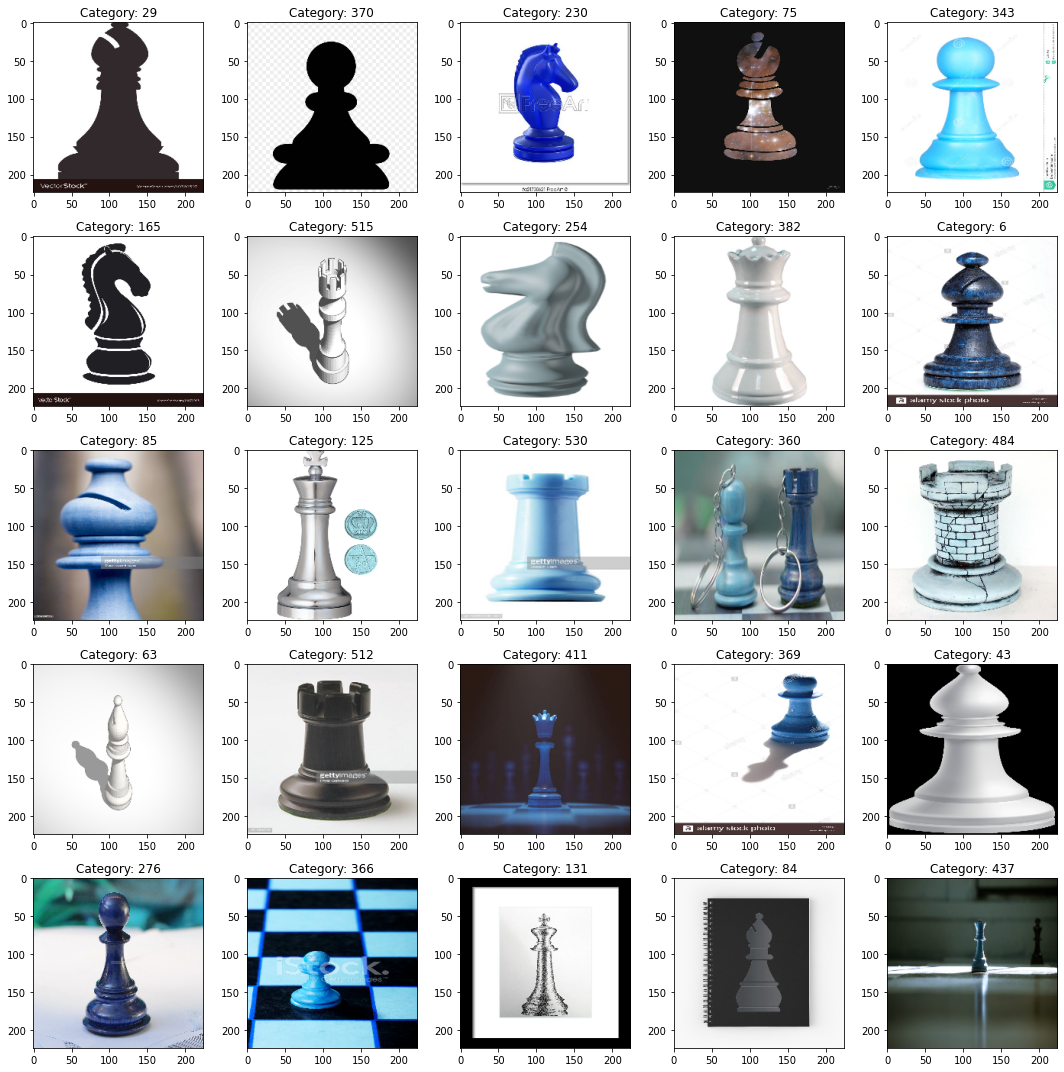

In [19]:
fig,ax=plt.subplots(5,5)
fig.set_size_inches(15,15)
print(len(Z))
for i in range(5):
    for j in range (5):
        l=rn.randint(0,len(Z))
        ax[i,j].imshow(XX[l])
        ax[i,j].set_title('Category: '+ str(l))
        
plt.tight_layout()

553467904/553467096 [==============================] - 41s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
___________________________________________________________

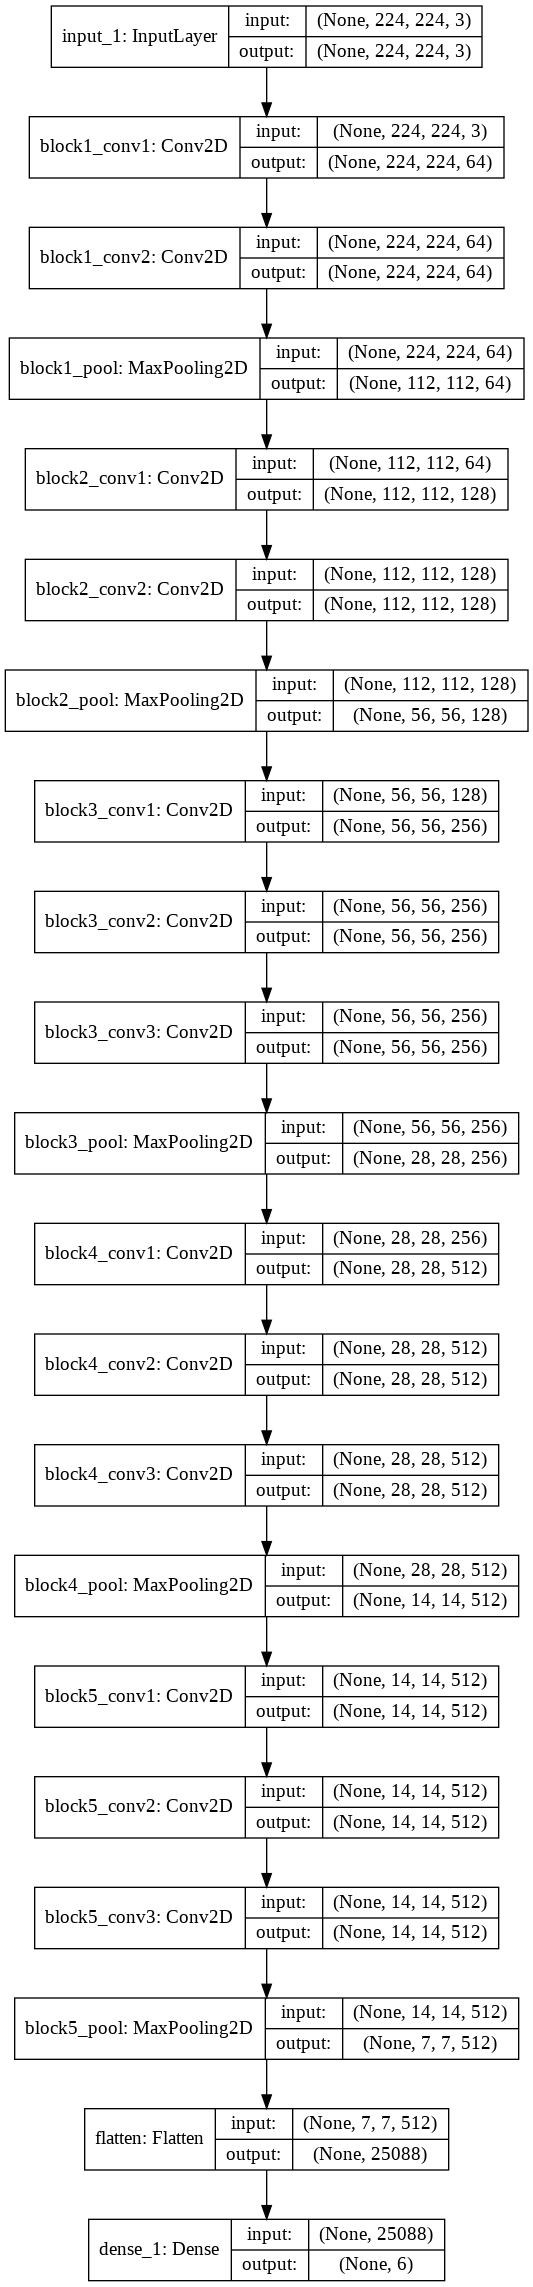

In [20]:
ct=0
base_model = VGG16(include_top=True,
                  input_shape = (imgsize,imgsize,3),
                  weights = 'imagenet')
base_model.summary()
base_model.layers.pop()
base_model.layers.pop()
base_model.layers.pop()


model = Sequential()
for layer in base_model.layers:
  model.add(layer)

for layer in base_model.layers:
  ct=ct+1

for layer in base_model.layers:
  if ct>4:
    layer.trainable = False
  else:
    layer.trainable = True
  ct=ct-1
  print(layer,layer.trainable)



# model.add(GlobalAveragePooling2D())
# model.add(Dropout(0.3))
# model.add(Flatten())

# model.add(regularizers.l2(0.01))

model.add(Dense(6,activation='softmax'))
model.summary()

SVG(model_to_dot(model).create(prog='dot', format='svg'))
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [22]:
checkpoint = ModelCheckpoint(
    './base.model',
    monitor='val_acc',
    verbose=1,
    save_best_only=True,
    mode='max',
    save_weights_only=False,
    period=1
)
earlystop = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=50,
    verbose=1,
    mode='auto'
)
tensorboard = TensorBoard(
    log_dir = './logs',
    histogram_freq=0,
    batch_size=16,
    write_graph=True,
    write_grads=True,
    write_images=False,
)

csvlogger = CSVLogger(
    filename= "training_csv.log",
    separator = ",",
    append = False
)

reduce = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=3,
    verbose=1, 
    mode='auto'
)

callbacks = [checkpoint,tensorboard,csvlogger,reduce]
# callbacks = [earlystop,tensorboard,csvlogger,reduce]

/usr/local/lib/python3.6/dist-packages/keras/callbacks/tensorboard_v2.py:92: UserWarning: The TensorBoard callback `batch_size` argument (for histogram computation) is deprecated with TensorFlow 2.0. It will be ignored.
  warnings.warn('The TensorBoard callback `batch_size` argument '
/usr/local/lib/python3.6/dist-packages/keras/callbacks/tensorboard_v2.py:97: UserWarning: The TensorBoard callback does not support gradients display when using TensorFlow 2.0. The `write_grads` argument is ignored.
  warnings.warn('The TensorBoard callback does not support '


In [23]:

opt = SGD(lr=1e-4,momentum=0.99)
opt1 = Adam(lr=1e-3)

model.compile(
    loss='categorical_crossentropy',
    optimizer=opt1,
    metrics=['accuracy']
)


history = model.fit_generator(
    augs_gen.flow(x_train,y_train,batch_size=32),
    validation_data  = (x_test,y_test),
    # steps_per_epoch  = 100,
    epochs =25, 
    verbose = 1,
    callbacks=callbacks
)

Epoch 1/25
14/14 [==============================] - 23s 2s/step - loss: 2.0950 - accuracy: 0.2404 - val_loss: 1.5922 - val_accuracy: 0.3694
Epoch 2/25


/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


14/14 [==============================] - 7s 489ms/step - loss: 1.4360 - accuracy: 0.4059 - val_loss: 1.0247 - val_accuracy: 0.6216
Epoch 3/25
14/14 [==============================] - 7s 489ms/step - loss: 1.0691 - accuracy: 0.6236 - val_loss: 0.8214 - val_accuracy: 0.6667
Epoch 4/25
14/14 [==============================] - 7s 489ms/step - loss: 0.9528 - accuracy: 0.6508 - val_loss: 0.9835 - val_accuracy: 0.6667
Epoch 5/25
14/14 [==============================] - 7s 489ms/step - loss: 0.7110 - accuracy: 0.7211 - val_loss: 0.4957 - val_accuracy: 0.8378
Epoch 6/25
14/14 [==============================] - 7s 489ms/step - loss: 0.6562 - accuracy: 0.7188 - val_loss: 0.6482 - val_accuracy: 0.7477
Epoch 7/25
14/14 [==============================] - 7s 489ms/step - loss: 0.5516 - accuracy: 0.7755 - val_loss: 0.5565 - val_accuracy: 0.7928
Epoch 8/25
14/14 [==============================] - 7s 489ms/step - loss: 0.4177 - accuracy: 0.8367 - val_loss: 1.1957 - val_accuracy: 0.6577

Epoch 00008: Red

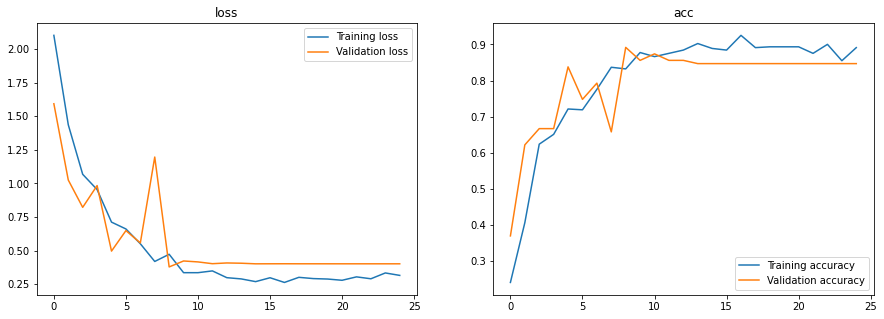

In [24]:
show_final_history(history)
# model.load_weights('./base.model')

# model_json = model.to_json()
# with open("model.json","w") as json_file:
#     json_file.write(model_json)
    
# model.save("model.h5")
# print("Weights Saved")

In [25]:
# use x 
a=model.evaluate(x_train,y_train)
b=model.evaluate(x_test,y_test)

print("Final loss of training data: {}".format(a[0]))
print("Accuracy of training data: {}".format(a[1]))
print("Final loss of test data: {}".format(b[0]))
print("Accuracy of test data: {}".format(b[1]))

ind=0

111/111 [==============================] - 1s 12ms/step
Final loss of training data: 0.16529359683698538
Accuracy of training data: 0.9365079402923584
Final loss of test data: 0.4011648246296891
Accuracy of test data: 0.8468468189239502


[[18  0  0  2  4  1]
 [ 0 12  0  0  4  0]
 [ 0  0 17  0  0  0]
 [ 1  1  0 19  0  1]
 [ 0  0  0  0  7  0]
 [ 0  0  0  1  2 21]]


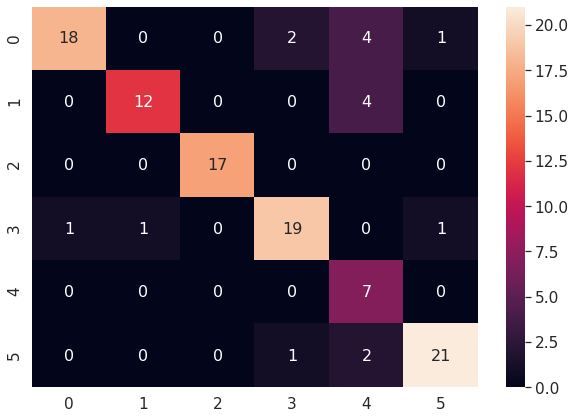

In [26]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

y_true=[]
y_pred=[]
# ['Bishop', 'King', 'Knight' , 'Pawn', 'Queen' , 'Rook']
classes=[0,1,2,3,4,5]

for ind in range(len(x_test)):
  a1,b1,c1=x_test[ind].shape
  ans1=np.argmax(model.predict(x_test[ind].reshape(1,a1,b1,c1)))
  y_pred.append(ans1)
  ans2=np.argmax(y_test[ind])
  y_true.append(ans2)
cm=confusion_matrix(y_true, y_pred, labels=classes)
print(cm)

df_cm = pd.DataFrame(cm, range(6), range(6))
plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) 
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) 
plt.show()

In [29]:
print("In the sequence Bishop,King,Knight,Pawn,Queen,Rook respectively")
cases=np.sum(cm)
tp = np.diag(cm)
fn = np.sum(cm, axis = 1) - tp
fp = np.sum(cm, axis = 0) - tp
tn = np.sum(cm) -  np.sum(cm, axis = 1) - np.sum(cm, axis = 0) + np.diag(cm)
print("Total number of cases: {}".format(cases))
print("Total number of true positives for Bishop,King,Knight,Pawn,Queen,Rook respectively: {}".format(tp))
print("Total number of false negatives for Bishop,King,Knight,Pawn,Queen,Rook respectively: {}".format(fn))
print("Total number of false positives for Bishop,King,Knight,Pawn,Queen,Rook respectively: {}".format(fp))
print("Total number of true negatives for Bishop,King,Knight,Pawn,Queen,Rook respectively: {}".format(tn))


In the sequence Bishop,King,Knight,Pawn,Queen,Rook respectively
Total number of cases: 111
Total number of true positives for Bishop,King,Knight,Pawn,Queen,Rook respectively: [18 12 17 19  7 21]
Total number of false negatives for Bishop,King,Knight,Pawn,Queen,Rook respectively: [7 4 0 3 0 3]
Total number of false positives for Bishop,King,Knight,Pawn,Queen,Rook respectively: [ 1  1  0  3 10  2]
Total number of true negatives for Bishop,King,Knight,Pawn,Queen,Rook respectively: [85 94 94 86 94 85]


In [28]:
recall=tp/(tp+fn)
precision=tp/(tp+fp)
accuracy=(tp+tn)/cases
specificity=tn/(fp+tn)
sensitivity=tp/(fn+tp)
print("recall on test dataset for Bishop,King,Knight,Pawn,Queen,Rook respectively: {}".format(recall))
print("precision on test dataset for Bishop,King,Knight,Pawn,Queen,Rook respectively: {}".format(precision))
print("accuracy on test dataset for Bishop,King,Knight,Pawn,Queen,Rook respectively: {}".format(accuracy))
print("Specificity on test dataset for Bishop,King,Knight,Pawn,Queen,Rook respectively: {}".format(specificity))
print("Sensitivity on test dataset for Bishop,King,Knight,Pawn,Queen,Rook respectively: {}".format(sensitivity))


recall on test dataset for Bishop,King,Knight,Pawn,Queen,Rook respectively: [0.72       0.75       1.         0.86363636 1.         0.875     ]
precision on test dataset for Bishop,King,Knight,Pawn,Queen,Rook respectively: [0.94736842 0.92307692 1.         0.86363636 0.41176471 0.91304348]
accuracy on test dataset for Bishop,King,Knight,Pawn,Queen,Rook respectively: [0.92792793 0.95495495 1.         0.94594595 0.90990991 0.95495495]
Specificity on test dataset for Bishop,King,Knight,Pawn,Queen,Rook respectively: [0.98837209 0.98947368 1.         0.96629213 0.90384615 0.97701149]
Sensitivity on test dataset for Bishop,King,Knight,Pawn,Queen,Rook respectively: [0.72       0.75       1.         0.86363636 1.         0.875     ]
